In [1]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
from skimage import color
import pickle

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [3]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [5]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc[:, :, 0])
    ret[:, :] = ycc[:, :, 0]
    return ret

In [6]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [7]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [8]:
train_dir = './train2017/'

num_train = 30000
image_names = os.listdir(train_dir)
image_names = random.sample(image_names, num_train)
print(len(image_names))

%matplotlib inline

30000


In [9]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3

In [11]:
def process_image(arr, H, W):
    if len(arr.shape) == 3:
        cropped = crop_center(arr, H, W)
        if cropped is not None:
            arr = RGBtoYCC(cropped)
            arr = np.divide(arr, 255)
            gray = YCCtoGray(arr)
            return gray, arr[:, :, 1:]
        return None, None
    return None, None

In [12]:
used_images = []
def generator(image_folder, batch_size):
    batch_features = np.zeros((batch_size, H, W, C))
    batch_labels = np.zeros((batch_size, H, W, C - 1))
    
    while True:
        count = 0
        while count < batch_size:
            filename = random.choice(image_names)
            arr = np.load(os.path.join(image_folder, filename))
            x, y = process_image(arr, H, W)
            if x is not None:
                used_images.append(filename)
                
                batch_features[count, :, :, :] = x
                batch_labels[count, :, :, :] = y

                count += 1
        yield (batch_features, batch_labels)

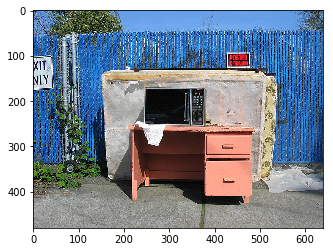

In [13]:
random_example = np.load("./train2017/000000436023.npy")
imshow(random_example)

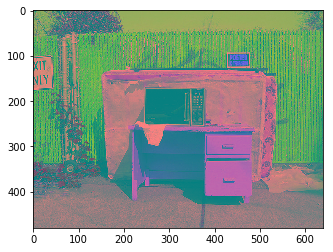

In [16]:
imshow(RGBtoYCC(random_example))

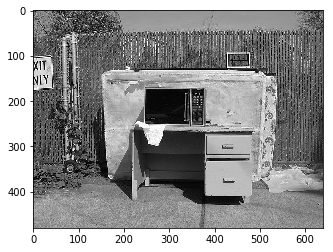

In [17]:
imshow(RGBtoGray(random_example), cmap="gray")

In [18]:
x, y = process_image(random_example, H, W)

(256, 256, 3)


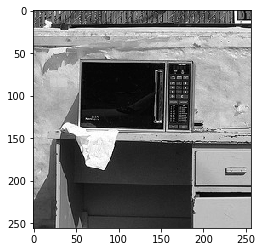

In [19]:
# the x
print(x.shape)
imshow(denormalize_image(x)[:, :, 0], cmap="gray")

(256, 256, 2)
0.0


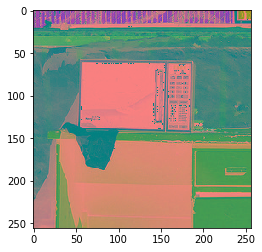

In [20]:
# the y
showing = np.zeros((y.shape[0], y.shape[1], y.shape[2] + 1))
print(y.shape)
showing[:, :, 0] = 255 * x[:, :, 0]
showing[:, :, 1:] = 255 * y
print(np.amax(showing - crop_center(RGBtoYCC(random_example), H, W)))
imshow(showing)

In [14]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /device:GPU:0


In [15]:
name_stem = 'model_augmented_loss_v4'
model_file = name_stem + '.json'
weights_file = name_stem + '.h5'
history_file = name_stem + '.pkl'
loss_file = name_stem + '.png'

model_path = os.path.join("./", model_file)
weights_path = os.path.join("./", weights_file)
use_saved = False
save = True
train = True

In [16]:
num_val = 100
val_folder = "./val2017"

X_val = np.zeros((num_val, H, W, C))
y_val = np.zeros((num_val, H, W, C - 1))

val_names = os.listdir(val_folder)

val_used = []

count = 0
while count < num_val:
    filename = random.choice(val_names)
    arr = np.load(os.path.join(val_folder, filename))
    x, y = process_image(arr, H, W)
    if x is not None:
        val_used.append(filename)
        X_val[count, :, :, :] = x
        y_val[count, :, :, :] = y
        count += 1
print(X_val.shape)
print(y_val.shape)
print(len(val_used))

(100, 256, 256, 3)
(100, 256, 256, 2)
100


In [19]:
lam = 1e-3
def my_loss_function(y_true, y_pred):
    loss1 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    loss2 = lam * tf.keras.backend.var(y_pred)
    return loss1 - loss2

In [20]:
input_shape = (H, W, C)

fusion_size = H // 8

model_input = tf.keras.layers.Input(shape=(H, W, 3,))

vgg = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=model_input,
                                    input_shape=input_shape)
for layer in vgg.layers:
    layer.trainable = False
    
inter_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
inter1 = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer(inter_layers[0]).output)
inter2 = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer(inter_layers[1]).output)
# inter3 = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer(inter_layers[2]).output)
# inter4 = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer(inter_layers[3]).output)

inter1_scale = inter1.output_shape[1] // fusion_size
inter2_scale = inter2.output_shape[1] // fusion_size
# inter3_scale = inter3.output_shape[1] // fusion_size
# inter4_scale = fusion_size // inter4.output_shape[1]

inter1Up = tf.keras.layers.MaxPooling2D(pool_size=inter1_scale)(inter1.output)
inter2Up = tf.keras.layers.MaxPooling2D(pool_size=inter2_scale)(inter2.output)
# inter3Up = tf.keras.layers.MaxPooling2D(pool_size=inter3_scale)(inter3.output)
# inter4Up = tf.keras.layers.UpSampling2D(size=inter4_scale)(inter4.output)
# print(inter1Up, inter2Up, inter3Up, inter4Up)

hyper = tf.keras.layers.Concatenate(axis=-1)([inter1Up, inter2Up])
print(hyper)


# Encoder
encoder_output = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(model_input)
encoder_output = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# Fusion
fusion_output = tf.keras.layers.concatenate([encoder_output, hyper], axis=3)
print(fusion_output)
fusion_output = tf.keras.layers.Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

# Decoder
decoder_output = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = tf.keras.layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)


my_model = None
if os.path.isfile(model_path) and os.path.isfile(weights_path) and use_saved:
    json_string = None
    with open(model_path, 'r') as f:
        json_string = json.load(f)
    my_model = tf.keras.models.model_from_json(json_string)
    my_model.load_weights(weights_path)
    print("loaded from save")
else:
    my_model = tf.keras.models.Model(inputs=model_input, outputs=decoder_output)

my_model.summary()

opt = tf.keras.optimizers.SGD(lr=0.001)
my_model.compile(loss=my_loss_function, optimizer=opt)

if train:
    history = my_model.fit_generator(generator(train_dir, 8), steps_per_epoch=3500, epochs=10, validation_data=(X_val, y_val))

if save:
    json_str = my_model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_str, outfile)
    my_model.save_weights(weights_path)
    print("saved weights and model")

Tensor("concatenate_2/concat:0", shape=(?, 32, 32, 192), dtype=float32)
Tensor("concatenate_3/concat:0", shape=(?, 32, 32, 448), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 128 73856       conv2d_15[0][0]                  
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792       

In [21]:
hist_dict = history.history
if save:
    pickle.dump(hist_dict, open(history_file, "wb"))

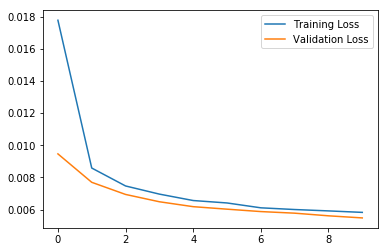

In [22]:
train_graph, = plt.plot(hist_dict["loss"], label='Training Loss')
val_graph, = plt.plot(hist_dict["val_loss"], label='Validation Loss')
plt.legend(handles=[train_graph, val_graph])
plt.savefig(loss_file)

In [41]:
image_name = random.choice(val_used)
showoff = np.load(os.path.join("./val2017/", image_name))
showoff_x, showoff_y = process_image(showoff, H, W)
prediction = my_model.predict(showoff_x[np.newaxis, :, :, :])
prediction = np.reshape(prediction, (H, W, 2))
print(image_name)
print(np.mean((prediction - showoff_y)**2))

000000477911.npy
0.005057147058163965


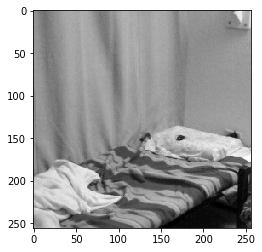

In [42]:
imshow(showoff_x)

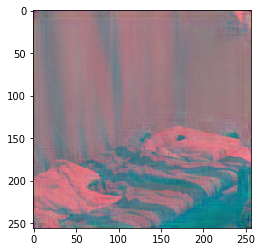

In [43]:
im = np.zeros((H, W, C))
im[:, :, 0] = showoff_x[:, :, 0]
im[:, :, 1] = prediction[:, :, 0]
im[:, :, 2] = prediction[:, :, 1]
im[im < 0] = 0
# im *= 255
imshow(im)

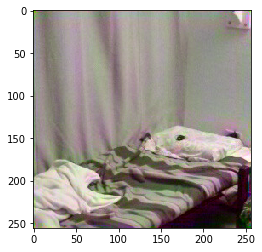

In [44]:
# converting into RGB gives us
imshow(YCCtoRGB(255 * im))

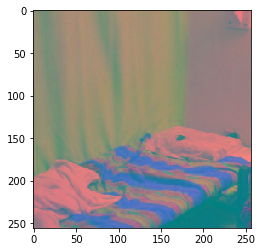

In [45]:
should_be = np.zeros((H, W, C))
should_be[:, :, 0] = showoff_x[:, :, 0]
should_be[:, :, 1] = showoff_y[:, :, 0]
should_be[:, :, 2] = showoff_y[:, :, 1]
# should_be *= 255

imshow(should_be)

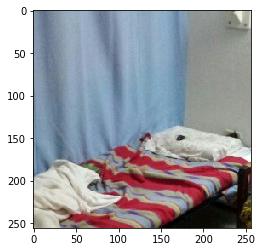

In [46]:
# real image
imshow(YCCtoRGB(255 * should_be))